#  Floating point observable training

This notebook is used to test that the code can handle floating point observables. It is used to check for bugs after code updates.

In [1]:
#  Required imports

print("Importing standard library")
import math, os, sys, time

print("Importing python data libraries")
import numpy as np
from matplotlib import cm, pyplot as plt
from scipy      import stats, special, integrate

print("Importing third party libraries")
import dill as pickle
import tensorflow as tf
import keras.backend as K

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.data_preparation import DataTable
from backends.density_model    import DensityModel, get_sum_gauss_density
from backends.plot             import plot_data, plot_ratio, plot_pull, get_ratio_1D
from backends.stats            import whiten_axes, unwhiten_axes
from backends.utils            import make_sure_dir_exists_for_filename

from backends import plot as plot, density_model as density_model

Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends


In [2]:
#  Inputs config

c_vals      = np.array([0, -10, -5, -1, 1, 5, 10]) / 20.
mu_limits   = [40, 500]
num_samples = int(1e5) # int(2e5)
    

In [3]:
#  Density model config

white_linear_fraction_data_space   = .9
white_linear_fraction_latent_space = 0.       # Keep 0, otherwise we get hard boundaries on latent space
whitening_num_points               = 200


In [4]:
#  Toy model

stored_integrals = {}

def mu_pdf_unnormed (mu, c=0) :
    mu_prime = (np.log(mu) - np.log(mu_limits[0])) / (np.log(mu_limits[-1]) - np.log(mu_limits[0]))
    c_prime  = np.fabs(c)      #  0.05 * np.fabs(c)
    pdf_zero = 1. / np.power(mu_prime + 1., 8) - (1./np.power(2., 8))
    modifier = 1. + c_prime*stats.norm.pdf(mu_prime, loc=1, scale=0.1)
    return pdf_zero * modifier

def get_integral (c, n=100) :
    global stored_integrals
    if c not in stored_integrals :
        stored_integrals[c] = integrate.fixed_quad(lambda x : mu_pdf_unnormed(x, c), mu_limits[0], mu_limits[-1], n=n)[0]
    return stored_integrals[c]

def mu_pdf (mu, c=0) :
    pdf      = mu_pdf_unnormed(mu, c)
    integral = get_integral(c)
    return pdf / integral

def mu_cdf (mu, c=0, n=100) :
    if type(mu) in [list, np.ndarray] :
        return np.array([mu_cdf(pmu, c=c) for pmu in mu])
    return integrate.fixed_quad(lambda x : mu_pdf(x, c), mu_limits[0], mu, n=n)[0]

def sample_pdf (n_sample, c=0, mu_resolution=0.1) :
    mu  = np.linspace(mu_limits[0], mu_limits[-1], 1+int((mu_limits[-1]-mu_limits[0])/mu_resolution))
    cdf = mu_cdf(mu, c)
    u   = np.random.uniform(size=(n_sample,))
    return np.interp(u, cdf, mu)


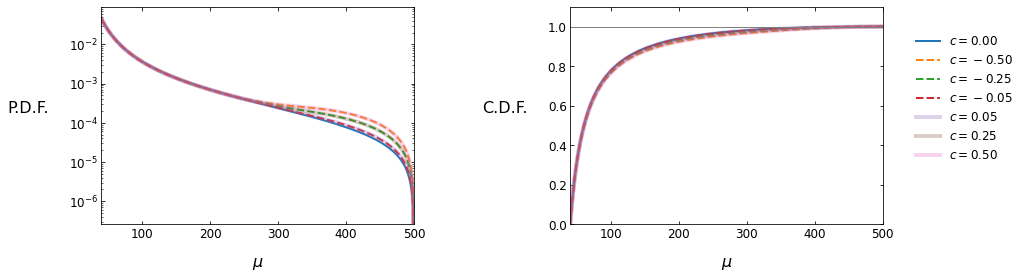

In [5]:
#  Plot PDF 

fig = plt.figure(figsize=(14, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.tick_params(which="both", direction="in", right=True, top=True, labelsize=12)
ax2.tick_params(which="both", direction="in", right=True, top=True, labelsize=12)

x  = np.linspace(mu_limits[0], mu_limits[-1], 500)
pdf_profile_SM, ymin, ymax = None, 1., 0.
for c in c_vals :
    pdf  = mu_pdf(x, c)
    cdf  = mu_cdf(x, c)
    ymax = np.max([ymax, np.max(pdf)])
    ymin = np.min([ymin, np.min([p for p in pdf if p>0])])
    if   c == 0 : 
        ax1.plot(x, pdf, "-" , lw=2, label=f"$c = {c:.2f}$")
        ax2.plot(x, cdf, "-" , lw=2, label=f"$c = {c:.2f}$")
        pdf_profile_SM = pdf
    elif c >  0 : 
        ax1.plot(x, pdf, "-" , lw=4, alpha=0.3, label=f"$c = {c:.2f}$")
        ax2.plot(x, cdf, "-" , lw=4, alpha=0.3, label=f"$c = {c:.2f}$")
    else        : 
        ax1.plot(x, pdf, "--", lw=2, label=f"$c = {c:.2f}$")
        ax2.plot(x, cdf, "--", lw=2, label=f"$c = {c:.2f}$")
ax1.set_xlim([x[0], x[-1]])
ax1.set_ylim([0.5*ymin, 2*ymax])
ax1.set_yscale("log")
ax1.set_xlabel("$\mu$" , labelpad=15, fontsize=16)
ax1.set_ylabel("P.D.F.", labelpad=20, fontsize=16, ha="right", rotation=0)

ax2.set_xlim([x[0], x[-1]])
ax2.set_ylim([0, 1.1])
ax2.set_xlabel("$\mu$" , labelpad=15, fontsize=16)
ax2.set_ylabel("C.D.F.", labelpad=20, fontsize=16, ha="right", rotation=0)
ax2.legend(loc=(1.09, 1-0.105*len(c_vals)), fontsize=12, frameon=False)
ax2.axhline(1, ls="-", lw=1, c="grey")

plt.subplots_adjust(hspace=0.01, wspace=0.5)
plt.show()


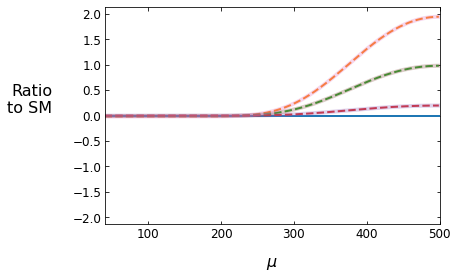

In [6]:
#  Plot PDF ratio to SM

def safe_vector_divide (A, B) :
    """return A / B, or NaN if B is 0"""
    if type(A) != np.ndarray : A = np.array(A)
    if type(B) != np.ndarray : B = np.array(B)
    assert len(A) == len(B)
    return np.array([Ab/Bp if (Bp != 0) else np.inf for Ab,Bp in zip(A,B)])
    

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=12)

ymax = 0.
for c in c_vals :
    ratio  = safe_vector_divide(mu_pdf(x, c), pdf_profile_SM) - 1.
    ymax = np.max([ymax, np.max(np.fabs(np.ma.masked_invalid(ratio)))])
    if   c == 0 : ax.plot(x, ratio, "-" , lw=2, label=f"$c = {c:.2f}$")
    elif c >  0 : ax.plot(x, ratio, "-" , lw=4, alpha=0.3, label=f"$c = {c:.1f}$")
    else        : ax.plot(x, ratio, "--", lw=2, label=f"$c = {c:.2f}$")
ax.set_xlim([x[0], x[-1]])
ax.set_ylim([- 1.1*ymax, 1.1*ymax])
ax.set_xlabel("$\mu$" , labelpad=15, fontsize=16)
ax.set_ylabel("Ratio\nto SM", labelpad=20, fontsize=16, ha="right", rotation=0)

plt.show()


In [7]:
#  Generate toy data

datasets, weights = {}, {}

for c in c_vals :
    data = sample_pdf(num_samples, c)
    datasets[c] = data.reshape((len(data), 1))
    weights [c] = np.full(shape=(num_samples,), fill_value=1./num_samples)
    

In [8]:
#  Whiten data
    
whitening_funcs = None

axis_configs = [[mu_limits[0], mu_limits[-1], whitening_num_points,  white_linear_fraction_data_space, white_linear_fraction_latent_space]]

initial_data, white_data = {}, {}

for c in c_vals :
    data = datasets[c]
    initial_data[c] = data
    print(f"Whitening dataset for {c:.2f}")
    white_data[c], whitening_funcs = whiten_axes (data, [float], axis_configs=axis_configs, whitening_funcs=whitening_funcs, func_form="step", alpha=4, beta=3, gamma=1)
            

Whitening dataset for 0.00
Whitening dataset for -0.50
Whitening dataset for -0.25
Whitening dataset for -0.05
Whitening dataset for 0.05
Whitening dataset for 0.25
Whitening dataset for 0.50


In [9]:
#  Get data range

def get_min (obj) :
    try : return np.min([get_min(o) for o in obj])
    except : pass
    return obj

def get_max (obj) :
    try : return np.max([get_max(o) for o in obj])
    except : pass
    return obj
    
def get_minmax (obj) :
    return get_min(obj), get_max(obj)
    
x_min, x_max = get_minmax([i for c,i in white_data.items()])

print(f"Observable limits are [{x_min:.3f}, {x_max:.3f}] (on latent space)")


Observable limits are [-5.000, 3.923] (on latent space)


In [10]:
#
#   Create density model  
#
density_model = DensityModel(name               = "S", 
                             num_gaussians      = 20, 
                             num_conditions     = 1, 
                             num_observables    = 1, 
                             verbose            = True,
                             learning_rate      = 0.001,
                             optimiser          = "adam",
                             types              = [float],
                             observables_limits = [[x_min, x_max]],
                             condition_limits   = [[np.min(c_vals), np.max(c_vals)]])
               

No observables_limits argument provided - assuming they are [-5, 5] for all observables
INFO       DensityModel.construct      Set model name              : S
INFO       DensityModel.construct      Set model num_gaussians     : 20
INFO       DensityModel.construct      Set model num_conditions    : 1
INFO       DensityModel.construct      Set model num_observables   : 1
INFO       DensityModel.construct      Set observable types        : [<class 'float'>]
INFO       DensityModel.construct      Set bias_initializer        : zeros
INFO       DensityModel.construct      Set learning_rate           : 0.001
INFO       DensityModel.construct      Set optimiser               : adam
INFO       DensityModel.construct      Set activation              : leakyrelu
INFO       DensityModel.construct      Set min_gauss_amplitude_frac: 0.2
INFO       DensityModel.build          Building model segment: S_observable0 for observable index 0
Projecting row index 0 from interval [-0.5, 0.5] onto [-2.0, 2.0

In [11]:
#
#   Make sure initial state does not evaluate to Inf or NaN
#
density_model.ensure_valid_over_dataset (white_data, weights)
                      

W0222 18:21:56.320634 4749882816 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2070: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Evaluating losses
-  observable logL are [-41.18662314], combined is -41.186623139581386
-  eval completed in 13s


In [12]:
#
#   Fit density model
#
density_model.fit(white_data , 
                  weights    ,
                  max_epochs_per_observable = 1000,
                  early_stopping_patience   = 3   ,
                  early_stopping_min_delta  = 0   ,
                  validation_split          = -1  ,
                  batch_size_per_observable = 1000)


INFO       DensityModel.fit            Queued the following observable indices to train: 0
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 1000
INFO       DensityModel.fit              -  Training setting: batch_size = 1000
INFO       DensityModel.fit              -  Training setting: validation_split = -1
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 3
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 700000 samples
Epoch 1/1000
700000/700000 [==============================] - 3s 4us/sample - loss: 2.5008e-05
Epoch 2/1000
700000/700000 [==============================] - 3s 4us/sample - loss: 1.3716e-05
Epoch 3/1000
700000/700000 [==============================] - 3s 4us/sample - loss: 1.3379e-05
Epoch 4/1000
700000/700000 [=======================

In [13]:
#  Check that evaluator model gives same result as prediction followed by manual calculation

test_data = white_data[0.]

logL1 = np.log(density_model.evaluate(0, test_data))[:,0]
logL2 = density_model.split_evaluator.predict([np.full(fill_value=0., shape=(num_samples,1)), test_data])[:,0]

print(f"c=0. with method 1 returns {np.mean(logL1):.3f} +/- {np.std(logL1):.3f}")
print(f"c=0. with method 2 returns {np.mean(logL2):.3f} +/- {np.std(logL2):.3f}")
print(f"the ratio is {np.mean(logL2/logL1):.3f} +/- {np.std(logL2/logL1):.3f}")


c=0. with method 1 returns -1.273 +/- 0.946
c=0. with method 2 returns -1.273 +/- 0.946
the ratio is 1.000 +/- 0.000


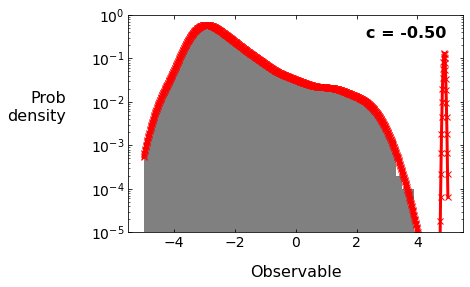

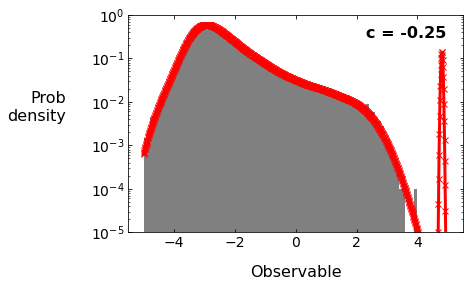

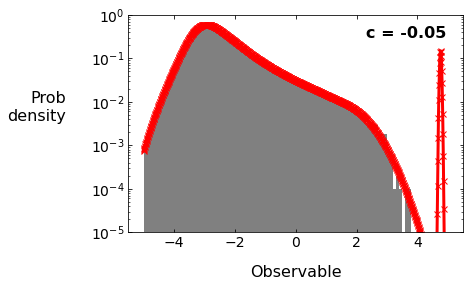

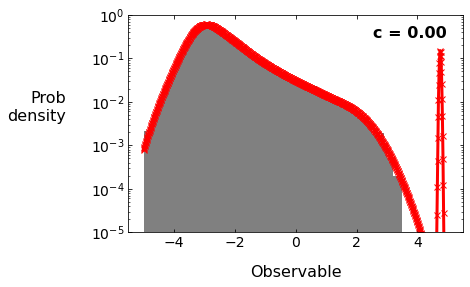

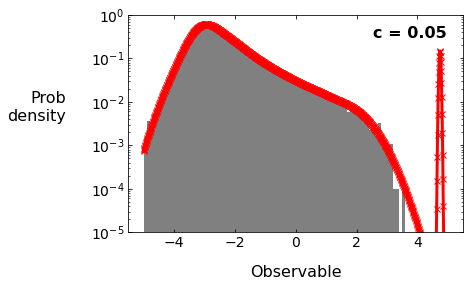

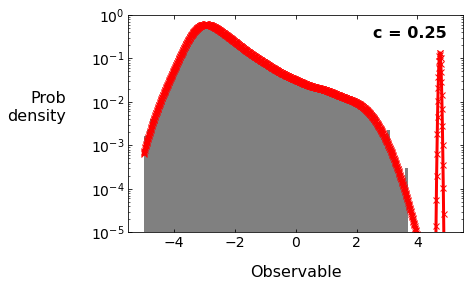

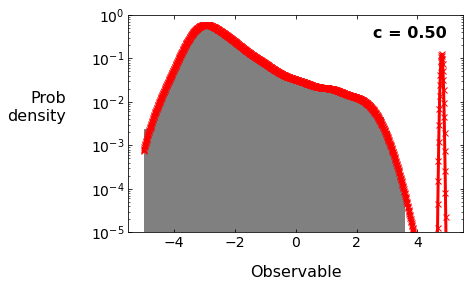

In [14]:
#  Plot trained model to make sure it learned something sensible

for c in sorted(c_vals) :
    fig = plt.figure(figsize=(6, 4))
    ax  = fig.add_subplot(1, 1, 1)
    ax.hist(white_data[c], density=True, bins=np.linspace(-5, 5, 101), color="grey")
    eval_pts = np.linspace(-5, 5, 1000).reshape([-1,1])
    pred_pts = density_model.evaluate(c, eval_pts).flatten()
    ax.plot(eval_pts, pred_pts, "x-", lw=3, c="r")
    ax.set_yscale("log")
    ax.set_ylim([1e-5, 1])
    ax.text(0.95, 0.95, f"c = {c:.2f}", weight="bold", transform=ax.transAxes, fontsize=16, ha="right", va="top")
    ax.set_xlabel("Observable", labelpad=15, fontsize=16)
    ax.set_ylabel("Prob\ndensity", labelpad=25, ha="right", fontsize=16, rotation=0)
    ax.tick_params(which="both", axis="both", direction="in", labelsize=14, right=True, top=True)
    plt.show()

In [16]:
#  Generate a large number of datapoints at 0.
#

n_gen = 1000000

print(f"Generating {n_gen} fake datapoints for c = 0")
start = time.time()
fake_white_datapoints_SM = density_model.sample(n_gen, 0)
end = time.time()
print(f"{n_gen} datapoints generated at (0, 0) in {int(end-start):.0f}s")

fake_white_datapoints = {}
for c in c_vals :
    start = time.time()
    fake_white_datapoints [c] = density_model.sample(n_gen, c)
    end = time.time()
    print(f"{n_gen} datapoints evaluated at {c} in {(end-start):.2f}s")
    

Generating 1000000 fake datapoints for c = 0
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 0
1000000 datapoints generated at (0, 0) in 5s
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 0
1000000 datapoints evaluated at 0.0 in 5.13s
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 0
1000000 datapoints evaluated at -0.5 in 5.21s
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 0
1000000 datapoints evaluated at -0.25 in 5.21s
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 0
1000000 datapoints evaluated at -0.05 in 5.22s
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 0
1000000 datapoints evaluated at 0.05 in 5.04s
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 0
1000000 datapoints evaluated at 0.25 in 5.01s
INF

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/li

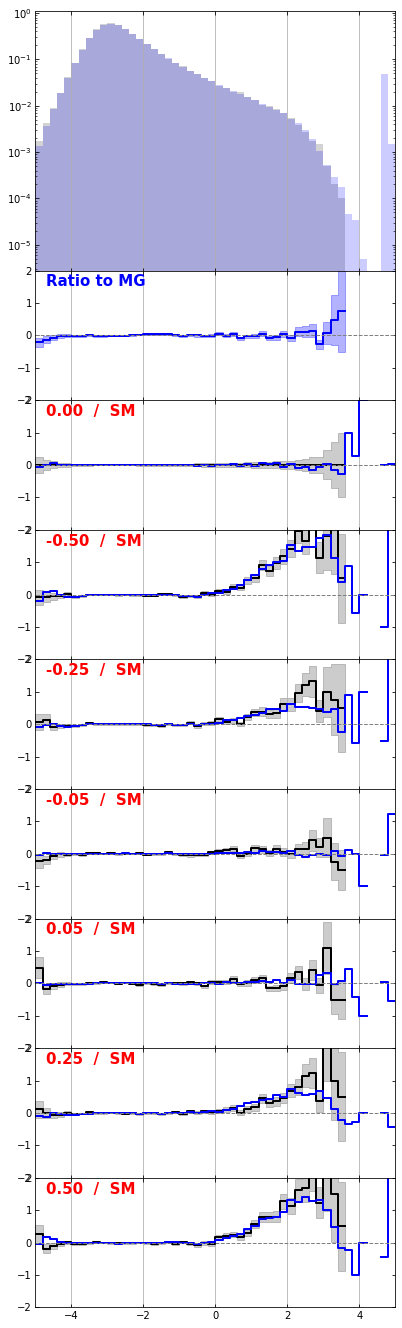

In [20]:

fig = plt.figure(figsize=(5, 2*(2+len(c_vals))))

pad_height = 1. / (3+len(c_vals))
lower      = 1. - 2*pad_height
ax = fig.add_axes([0, lower, 1, 2*pad_height])

bins = np.linspace(-5, 5, 51)
def get_histo (ds, weights=None) :
    if type(weights) == type(None) : weights = np.ones_like(ds)
    weights.reshape(ds.shape)
    bin_entries , _  = np.histogram(ds, weights=weights        , bins=bins)
    bin_variance, _  = np.histogram(ds, weights=weights*weights, bins=bins)
    frac_errors      = np.sqrt(bin_variance) / bin_entries
    return bin_entries / np.sum(weights), frac_errors

ds                                   = white_data[0][:,0]
bin_entries, frac_errors             = get_histo(ds)
bin_entries_model, frac_errors_model = get_histo(fake_white_datapoints_SM)
ax.hist(ds, density=True, color="darkgrey", alpha=0.5, bins=bins)
ax.hist(fake_white_datapoints_SM, density=True, color="blue", alpha=0.2, bins=bins)

ax.set_yscale("log")
ax.grid(which="both", axis="x")
ax.tick_params(which='both', axis="both", direction="in", right=True, top=True)
ax.set_xlim([-5, 5])

lower = lower - pad_height
ax    = fig.add_axes([0, lower, 1, pad_height]) 
ratio_to_MG       = bin_entries_model / bin_entries
ratio_to_MG_error = ratio_to_MG*np.sqrt(frac_errors*frac_errors + frac_errors_model*frac_errors_model)      
rat_x, rat_y, rat_ey = [], [], []
for idx, b in enumerate(bins) :
    rat_x.append(b)
    if (idx==0) or (idx==len(bins)-1) : continue
    rat_x.append(b)
for y, ey in zip(ratio_to_MG - 1, ratio_to_MG_error) :
    rat_y  .append(y  )
    rat_y  .append(y  )
    rat_ey .append(ey )
    rat_ey .append(ey )
rat_x, rat_y, rat_ey = np.array(rat_x), np.array(rat_y), np.array(rat_ey)
    
ax.plot(rat_x, rat_y, lw=2, color="b")
ax.fill_between(rat_x, rat_y-rat_ey, rat_y+rat_ey, color="b", alpha=0.3)
ax.axhline(0, ls="--", lw=1, c="grey")
ax.text(0.03, 0.97, "Ratio to MG", ha="left", va="top", transform=ax.transAxes, fontsize=15, color="b", weight="bold")
ax.grid(which="both", axis="x")
ax.tick_params(which='both', axis="both", direction="in", right=True, top=True)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])

for c in c_vals :
    lower = lower - pad_height
    ax = fig.add_axes([0, lower, 1, pad_height])
    
    ds = white_data[c][:,0]
    this_bin_entries, this_frac_errors = get_histo(ds)
    ratio_to_SM       = this_bin_entries / bin_entries
    ratio_to_SM_error = ratio_to_SM*np.sqrt(frac_errors*frac_errors + this_frac_errors*this_frac_errors)
    
    this_bin_entries_model, this_frac_errors_model = get_histo(fake_white_datapoints[c])
    ratio_to_SM_model       = this_bin_entries_model / bin_entries_model
    ratio_to_SM_error_model = ratio_to_SM_model*np.sqrt(frac_errors_model*frac_errors_model + this_frac_errors_model*this_frac_errors_model)
    
    rat_x, rat_y, rat_ey, rat_ym, rat_eym = [], [], [], [], []
    for idx, b in enumerate(bins) :
        rat_x.append(b)
        if (idx==0) or (idx==len(bins)-1) : continue
        rat_x.append(b)
    for y, ey, ym, eym in zip(ratio_to_SM - 1, ratio_to_SM_error, ratio_to_SM_model - 1, ratio_to_SM_error_model) :
        rat_y  .append(y  )
        rat_y  .append(y  )
        rat_ey .append(ey )
        rat_ey .append(ey )
        rat_ym .append(ym )
        rat_ym .append(ym )
        rat_eym.append(eym)
        rat_eym.append(eym)
    rat_x, rat_y, rat_ey, rat_ym, rat_eym = np.array(rat_x), np.array(rat_y), np.array(rat_ey), np.array(rat_ym), np.array(rat_eym)
    
    ax.plot(rat_x, rat_y, lw=2, color="k")
    ax.fill_between(rat_x, rat_y-rat_ey, rat_y+rat_ey, color="k", alpha=0.2)
    ax.plot(rat_x, rat_ym, lw=2, color="b")
    ax.axhline(0, ls="--", lw=1, c="grey")
    ax.text(0.03, 0.97, f"{c:.2f}  /  SM", ha="left", va="top", transform=ax.transAxes, fontsize=15, color="r", weight="bold")
    ax.grid(which="both", axis="x")
    ax.tick_params(which='both', axis="both", direction="in", right=True, top=True)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-2, 2])
        
plt.show()
